# Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, InputLayer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip,RandomRotation, RandomZoom
from glob import glob

### Importing Skin Cancer Data

In [2]:
## Mounting Google Drive: #Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166
# from google.colab import drive
# drive.mount('/content/gdrive')
# %pwd
# %cd "/content/gdrive/MyDrive/Google Colab/Upgrad ACPDL/Melanoma Detection Assignment"
# %pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive/Google Colab/Upgrad ACPDL/Melanoma Detection Assignment


'/content/gdrive/MyDrive/Google Colab/Upgrad ACPDL/Melanoma Detection Assignment'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Specify Paths of train and test directory to reuse at multiple places
train_path = 'dataset/Train'
test_path = 'dataset/Test'

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180
batch_input_shape = (batch_size,img_height,img_width, 3)

Use 80% of the images for training, and 20% for validation.

In [7]:
validation_split = 0.2

In [8]:
## Write your train dataset : load from the specified directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_path,seed=123,validation_split=validation_split,subset='training',batch_size=batch_size,image_size=(img_height,img_width))

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset: load from the specified directory
val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_path,seed=123,validation_split=validation_split,subset='validation',batch_size=batch_size,image_size=(img_height,img_width))

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

In [11]:
# Unbatching and picking atmost 1 image per class and storing them for plotting
train_ds_unbatched = train_ds.unbatch()
image_per_class = {}
for elem in train_ds_unbatched.as_numpy_iterator():
  if len(image_per_class) >= 9:
    break
  if elem[1] not in image_per_class:
    image_per_class[elem[1]] = elem[0]


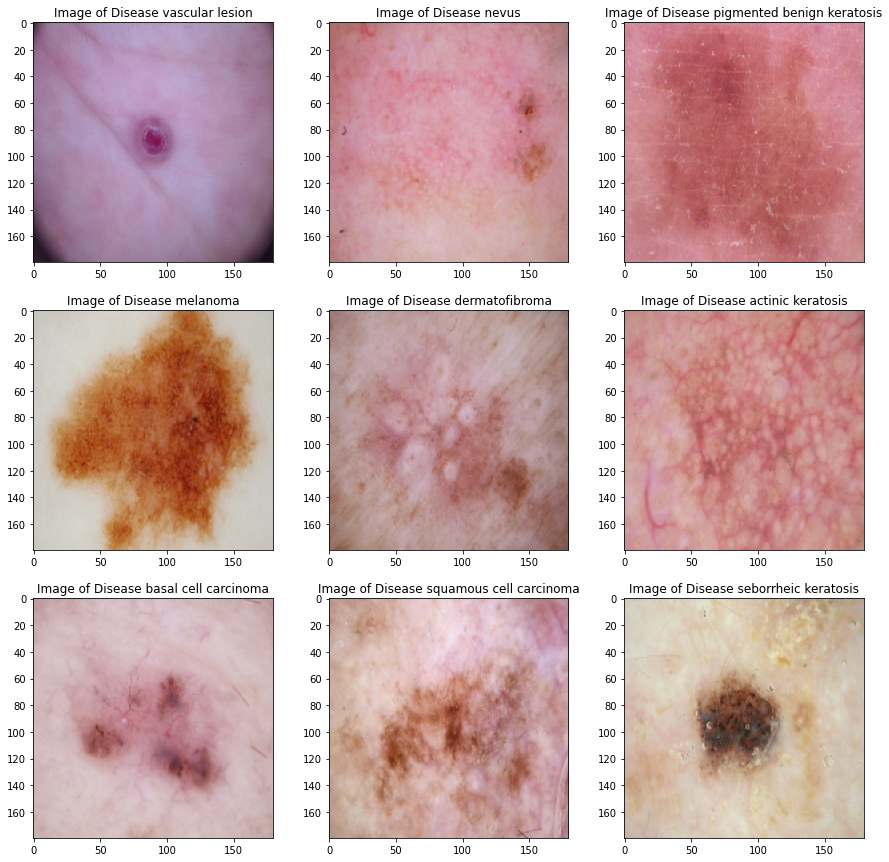

In [12]:
# Plotting image of each class
fig, axes = plt.subplots(3,3,figsize=(15,15))
for x in range(3):
  for y in range(3):
    idx = (x*3) + y
    (label,image) = list(image_per_class.items())[idx]
    axes[x,y].imshow(image/255.)
    axes[x,y].set_title(f"Image of Disease {class_names[label]}")

### DataSet Set up for Better Performance

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the base model
#### Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
base_model = Sequential()

#Rescaling Layer
base_model.add(Rescaling(scale=1./255.))

## Feature Learning Layers
base_model.add(Conv2D(filters=16, kernel_size = (3, 3), activation='relu', batch_input_shape=batch_input_shape))
base_model.add(MaxPool2D(strides=(2,2)))

base_model.add(Conv2D(filters=32, kernel_size = (3, 3), activation='relu'))
base_model.add(MaxPool2D(strides=(2,2)))

base_model.add(Conv2D(filters=64, kernel_size = (3, 3), activation='relu'))
base_model.add(MaxPool2D(strides=(2,2)))

## Classification Layers
base_model.add(Flatten())
base_model.add(Dense(128, activation='relu'))
base_model.add(Dense(len(class_names),activation='softmax'))

# Build the model
base_model.build(batch_input_shape)

### Compile the model with Adam Optimizer and SparseCategoricalCrossentropy For Loss

In [15]:
base_model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (32, 180, 180, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 178, 178, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 89, 89, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 87, 87, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 43, 43, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 41, 41, 64)          1

### Train the Base model

In [17]:
epochs = 20
history = base_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 227s 965ms/step - loss: 2.1843 - accuracy: 0.1780 - val_loss: 2.0142 - val_accuracy: 0.2192
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.9453 - accuracy: 0.2762 - val_loss: 1.7961 - val_accuracy: 0.3624
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.7230 - accuracy: 0.3817 - val_loss: 1.5560 - val_accuracy: 0.4966
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5233 - accuracy: 0.4615 - val_loss: 1.4567 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4294 - accuracy: 0.4994 - val_loss: 1.4268 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3615 - accuracy: 0.5167 - val_loss: 1.3828 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3520 - accuracy: 0.5273 - val_loss: 1.4077 - val_accuracy: 0.5213
Epoch 8/20

### Visualizing training results

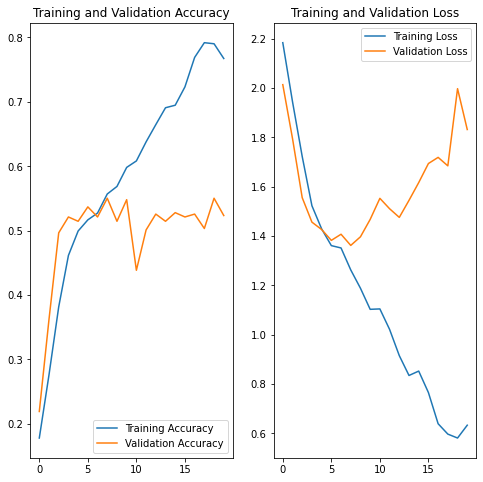

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings from Base Model

- Model clearly overfits. Training Accuracy increases with the number of epochs. But Validation Accuracy becomes more or less stagnant midway.
- Model learnt noise along with patterns and thus, the training accuracy is high and validation accuracy is low

## Data Augmentation

In [19]:
# Using RandomFlip, RandomRotation and RandomZoom as data augmentation strategies
data_augumentation_layers = [
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.3),
    RandomZoom(0.5,0.2)
]
data_augumentation = Sequential(data_augumentation_layers)

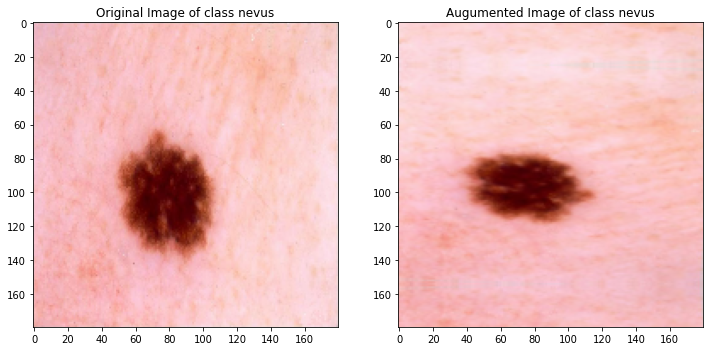

In [20]:
# Check how Augmentation works (visually) for a sample image from training data
fig, axes = plt.subplots(1,2,figsize=(12,12))
for image,label in train_ds_unbatched.take(1):
  axes[0].imshow(image/255.)
  axes[0].set_title(f"Original Image of class {class_names[label]}")
  img = tf.cast(tf.expand_dims(image, 0), tf.float32)
  aug_img = data_augumentation(img)
  axes[1].imshow(aug_img[0]/255.)
  axes[1].set_title(f"Augmented Image of class {class_names[label]}")

## Create the model, compile and train the Data Augmented (as a layer) model


In [21]:
data_aug_model = Sequential()

# Data Augumentation layer
data_aug_model.add(data_augumentation)

#Rescaling Layer
data_aug_model.add(Rescaling(scale=1./255.))

## Feature Learning Layers
data_aug_model.add(Conv2D(filters=16, kernel_size = (3, 3), activation='relu',batch_input_shape=batch_input_shape))
data_aug_model.add(BatchNormalization())
data_aug_model.add(MaxPool2D(strides=(2,2)))
data_aug_model.add(Dropout(0.25))

data_aug_model.add(Conv2D(filters=32, kernel_size = (3, 3), activation='relu'))
data_aug_model.add(BatchNormalization())
data_aug_model.add(MaxPool2D(strides=(2,2)))
data_aug_model.add(Dropout(0.25))

data_aug_model.add(Conv2D(filters=64, kernel_size = (3, 3), activation='relu'))
data_aug_model.add(BatchNormalization())
data_aug_model.add(MaxPool2D(strides=(2,2)))
data_aug_model.add(Dropout(0.25))

## Classification Layers
data_aug_model.add(Flatten())
data_aug_model.add(Dense(128, activation='relu'))
data_aug_model.add(Dropout(0.4))

data_aug_model.add(Dense(len(class_names),activation='softmax'))

# Build the model
data_aug_model.build(batch_input_shape)

### Compiling the model

In [22]:
data_aug_model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [23]:
# View the Model Summary
data_aug_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (32, 178, 178, 16)        448       
                                                                 
 batch_normalization (BatchN  (32, 178, 178, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 89, 89, 16)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (32, 89, 89, 16)         

### Training the model

In [24]:
epochs = 20
history = data_aug_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 40ms/step - loss: 3.8117 - accuracy: 0.2310 - val_loss: 11.3849 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 2s 32ms/step - loss: 2.0726 - accuracy: 0.3080 - val_loss: 12.7833 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 2s 32ms/step - loss: 2.0138 - accuracy: 0.2840 - val_loss: 14.2931 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 2s 32ms/step - loss: 1.9182 - accuracy: 0.3047 - val_loss: 6.2398 - val_accuracy: 0.1544
Epoch 5/20
56/56 [==============================] - 2s 32ms/step - loss: 1.9279 - accuracy: 0.3108 - val_loss: 4.9617 - val_accuracy: 0.2192
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.9592 - accuracy: 0.2980 - val_loss: 4.0656 - val_accuracy: 0.1790
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.9084 - accuracy: 0.3119 - val_loss: 2.7011 - val_accuracy: 0.1924
Epoch 8/20

### Visualizing the results

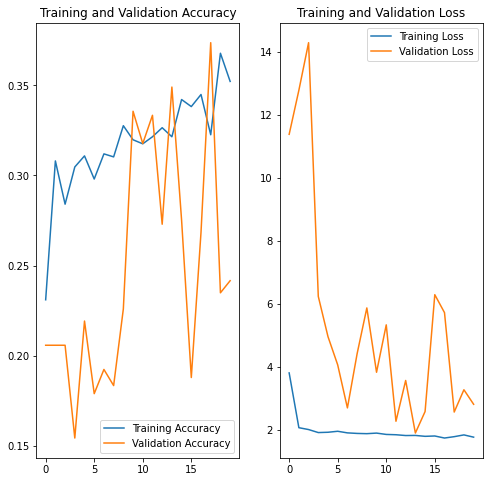

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Observation
- Even though training and validation accuracy came closer, both are of low value. This indicates clearly that model underfits

#### Finding Class Distribution
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
# Fetching the path excluding the output folder
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]


In [27]:
# Creating Df with path and label
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [28]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

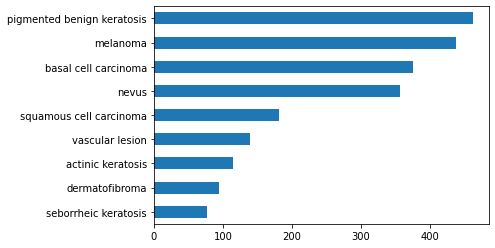

In [29]:
# Plot bar chart to understand the number of images in each class
original_df['Label'].value_counts().sort_values().plot(kind = 'barh')

#### Findings
#### - Which class has the least number of samples?
        seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
        (In decreasing order)
        pigmented benign keratosis
        melanoma
        basal cell carcinoma 
        nevus 



##Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
path_to_training_dataset=train_path + "/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEC3E5E1150>: 100%|██████████| 500/500 [00:20<00:00, 24.11 Samples/s]


Initialised with 376 image(s) found.
Output directory set to dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEC3E60D450>: 100%|██████████| 500/500 [00:22<00:00, 22.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEC3E5D5690>: 100%|██████████| 500/500 [00:23<00:00, 21.28 Samples/s]


Initialised with 438 image(s) found.
Output directory set to dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FEBACC9CAD0>: 100%|██████████| 500/500 [01:41<00:00,  4.93 Samples/s]


Initialised with 357 image(s) found.
Output directory set to dataset/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2012x1956 at 0x7FEBACD13D10>: 100%|██████████| 500/500 [01:30<00:00,  5.52 Samples/s]


Initialised with 462 image(s) found.
Output directory set to dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEBACC4E610>: 100%|██████████| 500/500 [00:19<00:00, 26.25 Samples/s]


Initialised with 77 image(s) found.
Output directory set to dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FEBAA03AC90>: 100%|██████████| 500/500 [00:42<00:00, 11.80 Samples/s]


Initialised with 181 image(s) found.
Output directory set to dataset/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEBACC51310>: 100%|██████████| 500/500 [00:18<00:00, 26.80 Samples/s]


Initialised with 139 image(s) found.
Output directory set to dataset/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEC3E5D52D0>: 100%|██████████| 500/500 [00:18<00:00, 27.24 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

# Look at a sample path 
print(f"Length of the path list (= Total number of images added by Augmentor): {len(path_list_new)}")
path_list_new[0]

Length of the path list (= Total number of images added by Augmentor): 4500


'dataset/Train/melanoma/output/melanoma_original_ISIC_0000303.jpg_31476f67-fb57-471a-932d-d1fa5676e33b.jpg'

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# Look at a sample lesion
lesion_list_new[0]

'melanoma'

In [35]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [37]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

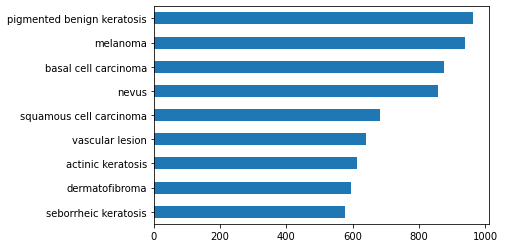

In [38]:
new_df['Label'].value_counts().sort_values().plot(kind = 'barh')

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Train the model on the data created using Augmentor

In [39]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [40]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train, #Already points the train directory
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Optimize the data fetch

In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Creating Final Model after dealing with Class Imbalance

In [43]:
final_model = Sequential()

#Rescaling Layer
final_model.add(Rescaling(scale=1./255.))

## Feature Learning Layers
final_model.add(Conv2D(filters=16, kernel_size = (3, 3), activation='relu',batch_input_shape=batch_input_shape))
final_model.add(BatchNormalization())
final_model.add(MaxPool2D(strides=(2,2)))
final_model.add(Dropout(0.25))

final_model.add(Conv2D(filters=32, kernel_size = (3, 3), activation='relu'))
final_model.add(BatchNormalization())
final_model.add(MaxPool2D(strides=(2,2)))
final_model.add(Dropout(0.25))

final_model.add(Conv2D(filters=64, kernel_size = (3, 3), activation='relu'))
final_model.add(BatchNormalization())
final_model.add(MaxPool2D(strides=(2,2)))
final_model.add(Dropout(0.25))

## Classification Layers
final_model.add(Flatten())
final_model.add(Dense(128, activation='relu'))
final_model.add(Dropout(0.4))

final_model.add(Dense(len(class_names),activation='softmax'))

# Build the model
final_model.build(batch_input_shape)

#### Compile your model (Choose optimizer and loss function appropriately)

In [44]:
final_model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [45]:
# Print Model Summary to look at Input Output shapes and parameters
final_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 178, 178, 16)        448       
                                                                 
 batch_normalization_3 (Batc  (32, 178, 178, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 89, 89, 16)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (32, 89, 89, 16)          0         
                                                                 
 conv2d_7 (Conv2D)           (32, 87, 87, 32)         

#### Train the model

In [46]:
epochs = 30
history = final_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 54s 64ms/step - loss: 2.9591 - accuracy: 0.2235 - val_loss: 8.2648 - val_accuracy: 0.1084
Epoch 2/30
169/169 [==============================] - 5s 29ms/step - loss: 1.9264 - accuracy: 0.2878 - val_loss: 6.5309 - val_accuracy: 0.1321
Epoch 3/30
169/169 [==============================] - 5s 29ms/step - loss: 1.8243 - accuracy: 0.3190 - val_loss: 2.8951 - val_accuracy: 0.2324
Epoch 4/30
169/169 [==============================] - 5s 29ms/step - loss: 1.7379 - accuracy: 0.3364 - val_loss: 5.6895 - val_accuracy: 0.2806
Epoch 5/30
169/169 [==============================] - 5s 29ms/step - loss: 1.6657 - accuracy: 0.3531 - val_loss: 3.0406 - val_accuracy: 0.3066
Epoch 6/30
169/169 [==============================] - 5s 29ms/step - loss: 1.6454 - accuracy: 0.3635 - val_loss: 2.7699 - val_accuracy: 0.2866
Epoch 7/30
169/169 [==============================] - 5s 29ms/step - loss: 1.5758 - accuracy: 0.3817 - val_loss: 4.9876 - val_accuracy: 0.339

#### Visualize the model results

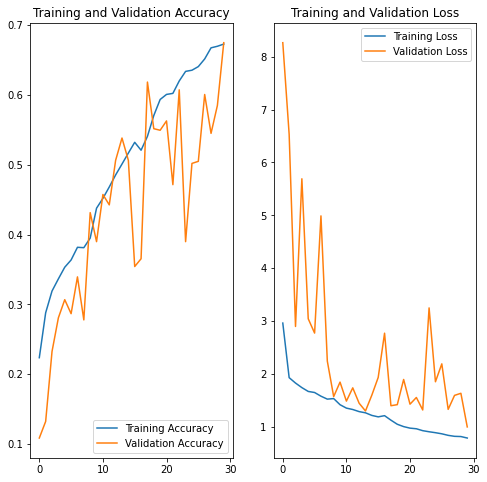

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:
 - Yes Addressing Class Imbalance tries to improve both Training and Validation Accuracy

